# Evaluation of Graph Neural Network segment classifier

In [1]:
%pwd

'/global/u2/d/danieltm/ExaTrkX/eta-tracker/notebooks'

In [2]:
# System imports
import os
import sys
import pprint

# External imports
import matplotlib.pyplot as plt
import numpy as np

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from trainers import get_trainer
from nb_utils import (load_config_file, load_config_dir, load_summaries,
                      plot_train_history, get_test_data_loader,
                      compute_metrics, plot_metrics, draw_sample_xy)

In [3]:
%matplotlib inline

## Load training results

Specify which results to load either by config file or training output directory.

In [8]:
# Load by config file
config_file = '../configs/count_small.yaml'
config = load_config_file(config_file)
summaries = load_summaries(config)
print('\nTraining summaries:')
summaries


Training summaries:


,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.100,0.388274,32272.285884,717.366645,0,3.891611,0.338036,0.836585,0.472072
1,0.100,0.318021,32297.936126,738.732257,1,3.258168,0.242515,0.908537,0.433859
2,0.100,0.304637,32319.277058,754.570493,2,3.211485,0.337512,0.841463,0.441100
3,0.100,0.289634,32280.017525,762.708018,3,3.246258,0.240221,0.932927,0.431873
4,0.100,0.256279,32379.038571,769.253229,4,3.268085,0.212888,0.913415,0.435254
...,...,...,...,...,...,...,...,...,...
59,0.001,0.180598,33174.560904,860.853036,59,3.468087,0.158373,0.975610,0.462291
60,0.001,0.180585,33173.877924,860.884889,60,3.400271,0.158431,0.975610,0.432868
61,0.001,0.180550,33172.861851,860.893230,61,3.218958,0.158217,0.975610,0.440850
62,0.001,0.180600,33172.142853,860.929797,62,3.274555,0.158604,0.975610,0.426049


In [6]:
# Load by directory (preferred)
result_base = os.path.expandvars('$SCRATCH/ExaTrkX/counter_results')

In [56]:
ls $result_base

agnn01/  agnn03/  agnn05/  agnn07/            checkpoints_med_000/
agnn02/  agnn04/  agnn06/  checkpoints_high/  checkpoints_tiny_000/


In [7]:
# result_name = 'checkpoints_high/agnn002'
result_name = 'counter001'
result_dir = os.path.join(result_base, result_name)

config = load_config_dir(result_dir)
print('Configuration:')
pprint.pprint(config)

summaries = load_summaries(config)
print('\nTraining summaries:')
summaries

Configuration:
{'data': {'batch_size': 1,
          'input_dir': '/global/cscratch1/sd/danieltm/ExaTrkX/counter_data/hitgraphs_small_000',
          'n_train': 160,
          'n_valid': 40,
          'n_workers': 4,
          'name': 'hitgraphs_sparse',
          'real_weight': 3.0},
 'model': {'hidden_dim': 64,
           'input_dim': 3,
           'layer_norm': True,
           'loss_func': 'binary_cross_entropy_with_logits',
           'max_tracks': 40,
           'n_graph_iters': 4,
           'name': 'counter'},
 'n_ranks': 1,
 'optimizer': {'learning_rate': 0.1,
               'lr_decay_schedule': [{'end_epoch': 20,
                                      'factor': 0.5,
                                      'start_epoch': 10},
                                     {'end_epoch': 40,
                                      'factor': 0.1,
                                      'start_epoch': 20},
                                     {'end_epoch': 50,
                                      

FileNotFoundError: [Errno 2] File b'/global/cscratch1/sd/danieltm/ExaTrkX/doublet_results/counter001/summaries_0.csv' does not exist: b'/global/cscratch1/sd/danieltm/ExaTrkX/doublet_results/counter001/summaries_0.csv'

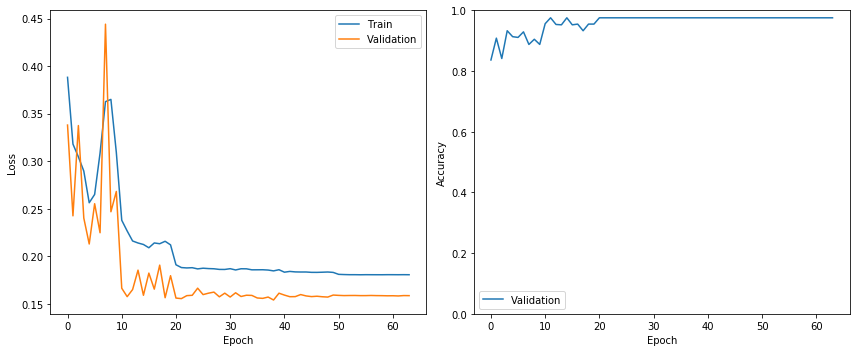

In [9]:
plot_train_history(summaries)

Text(0, 0.5, 'Learning rate')

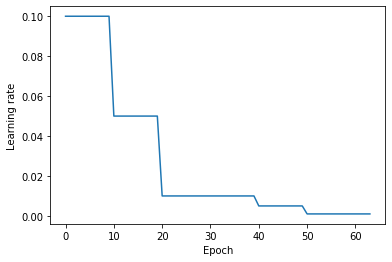

In [10]:
# Plot the learning rate
plt.figure()
plt.plot(summaries.lr)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')

## Load the trained model

In [11]:
# Find the best epoch
best_idx = summaries.valid_loss.idxmin()
summaries.loc[[best_idx]]

,lr,train_loss,l1,l2,epoch,train_time,valid_loss,valid_acc,valid_time
38,0.01,0.184588,33259.159326,860.759596,38,3.471613,0.153942,0.97561,0.455868


In [12]:
# Build the trainer and load best checkpoint
trainer = get_trainer(output_dir=config['output_dir'], **config['trainer'])
trainer.build_model(optimizer_config=config['optimizer'], **config['model'])

best_epoch = summaries.epoch.loc[best_idx]
trainer.load_checkpoint(checkpoint_id=best_epoch)

print(trainer.model)
print('Parameters:', sum(p.numel() for p in trainer.model.parameters()))

GNNTrackCounter(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=134, out_features=64, bias=True)
      (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
      (8): Tanh()
      (9): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=201, out_features=64, bias=True)
      (1): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
      (2)

## Evaluate the model on the test dataset

In [13]:
# Load the test dataset
n_test = 16
test_loader = get_test_data_loader(config, n_test=n_test)

In [14]:
%%time
# Apply the model
test_preds, test_targets = trainer.predict(test_loader)

CPU times: user 682 ms, sys: 64.6 ms, total: 747 ms
Wall time: 793 ms


In [15]:
threshold = 0.5
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.5
Accuracy:  0.9756
Precision: 0.0000
Recall:    0.0000


/usr/common/software/pytorch/v1.1.0/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
threshold = 0.8
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.8
Accuracy:  0.9744
Precision: 0.9314
Recall:    0.9465


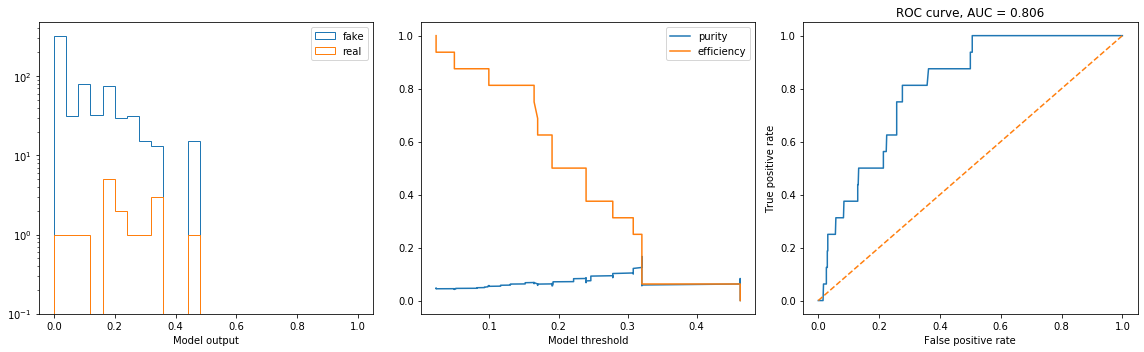

In [16]:
plot_metrics(test_preds, test_targets, test_metrics)

## Visualize predictions

In [18]:
n_phi_sections = 4
feature_scale = np.array([1000., np.pi / n_phi_sections, 1000.])

In [30]:
for i in range(n_test):
    g = test_loader.dataset[i]
    e = g.edge_index.numpy()
    x = g.x.numpy() * feature_scale
    y = g.y.numpy()
    o = test_preds[i].numpy()
    print(i, " with max_track number: ", len(y), " and hit number: ", len(x), np.argmax(o), np.argmax(y))

0  with max_track number:  41  and hit number:  123 16 22
1  with max_track number:  41  and hit number:  109 16 15
2  with max_track number:  41  and hit number:  95 16 16
3  with max_track number:  41  and hit number:  71 16 12
4  with max_track number:  41  and hit number:  92 16 17
5  with max_track number:  41  and hit number:  102 16 14
6  with max_track number:  41  and hit number:  58 16 12
7  with max_track number:  41  and hit number:  46 16 9
8  with max_track number:  41  and hit number:  107 16 21
9  with max_track number:  41  and hit number:  98 16 17
10  with max_track number:  41  and hit number:  114 16 27
11  with max_track number:  41  and hit number:  56 16 9
12  with max_track number:  41  and hit number:  67 16 7
13  with max_track number:  41  and hit number:  101 16 14
14  with max_track number:  41  and hit number:  131 16 18
15  with max_track number:  41  and hit number:  63 16 17


In [29]:
np.argmax(o), np.argmax(y)

(16, 22)

In [21]:
i = 0

g = test_loader.dataset[i]
e = g.edge_index.numpy()
x = g.x.numpy() * feature_scale
y = g.y.numpy()
o = test_preds[i].numpy()

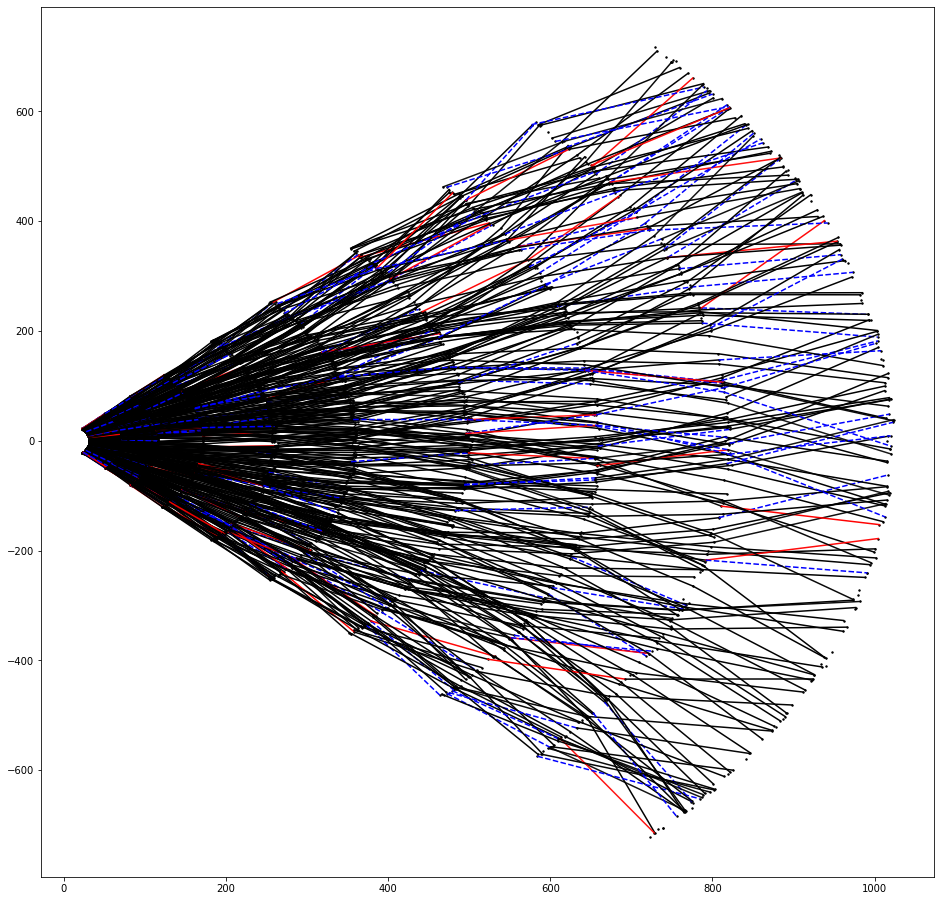

In [17]:
draw_sample_xy(x, e, o, y, cut=0.9);